##**CNN Model for Image Classification**

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

**Change the Working Directory**

In [ ]:
# Change the working directory to the location of the dataset
%cd /kaggle/input/food-101/

[Errno 2] No such file or directory: '/kaggle/input/food-101/'
/content


# **Downloading and Extracting the Dataset**

Download and extract the Food-101 dataset. This dataset contains images of food from 101 categories and will be used for training and evaluating the CNN model. The following function checks if the dataset already exists in the working directory. If not, it downloads the dataset from the specified URL and extracts it for use.

In [ ]:
# Download and extract data
def get_data():
  if 'food-101' in os.listdir():
    print('Dataset already exists')
  else:
    print('Downloading the data')
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print('Dataset downloaded!')
    print('Extracting data')
    !tar xzvf food-101.tar.gz
    print('Extraction done!')

In [ ]:
get_data()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [ ]:
# List the files in the 'food-101/images' directory
os.listdir('food-101/images')

['tuna_tartare',
 'fried_calamari',
 'miso_soup',
 'greek_salad',
 'apple_pie',
 'mussels',
 'baklava',
 'prime_rib',
 'peking_duck',
 'spaghetti_bolognese',
 'club_sandwich',
 'filet_mignon',
 'onion_rings',
 'fish_and_chips',
 'lobster_bisque',
 'fried_rice',
 'oysters',
 'tiramisu',
 'hot_dog',
 'dumplings',
 'caprese_salad',
 'risotto',
 'donuts',
 'churros',
 'crab_cakes',
 'pho',
 'poutine',
 'baby_back_ribs',
 'deviled_eggs',
 'tacos',
 'pork_chop',
 'guacamole',
 'pad_thai',
 'sashimi',
 'spaghetti_carbonara',
 'ice_cream',
 'breakfast_burrito',
 'chocolate_mousse',
 'edamame',
 'eggs_benedict',
 'croque_madame',
 'garlic_bread',
 'macaroni_and_cheese',
 'falafel',
 'beef_carpaccio',
 'sushi',
 'samosa',
 'nachos',
 'french_fries',
 'lasagna',
 'shrimp_and_grits',
 'beignets',
 'escargots',
 'pulled_pork_sandwich',
 'strawberry_shortcake',
 'gyoza',
 'ceviche',
 'cheesecake',
 'cup_cakes',
 'pancakes',
 'grilled_cheese_sandwich',
 'steak',
 'huevos_rancheros',
 'cannoli',
 'piz

In [ ]:
# List the files in the 'food-101/meta' directory
os.listdir('food-101/meta')

['train.json',
 'test.txt',
 'classes.txt',
 'test.json',
 'labels.txt',
 'train.txt']

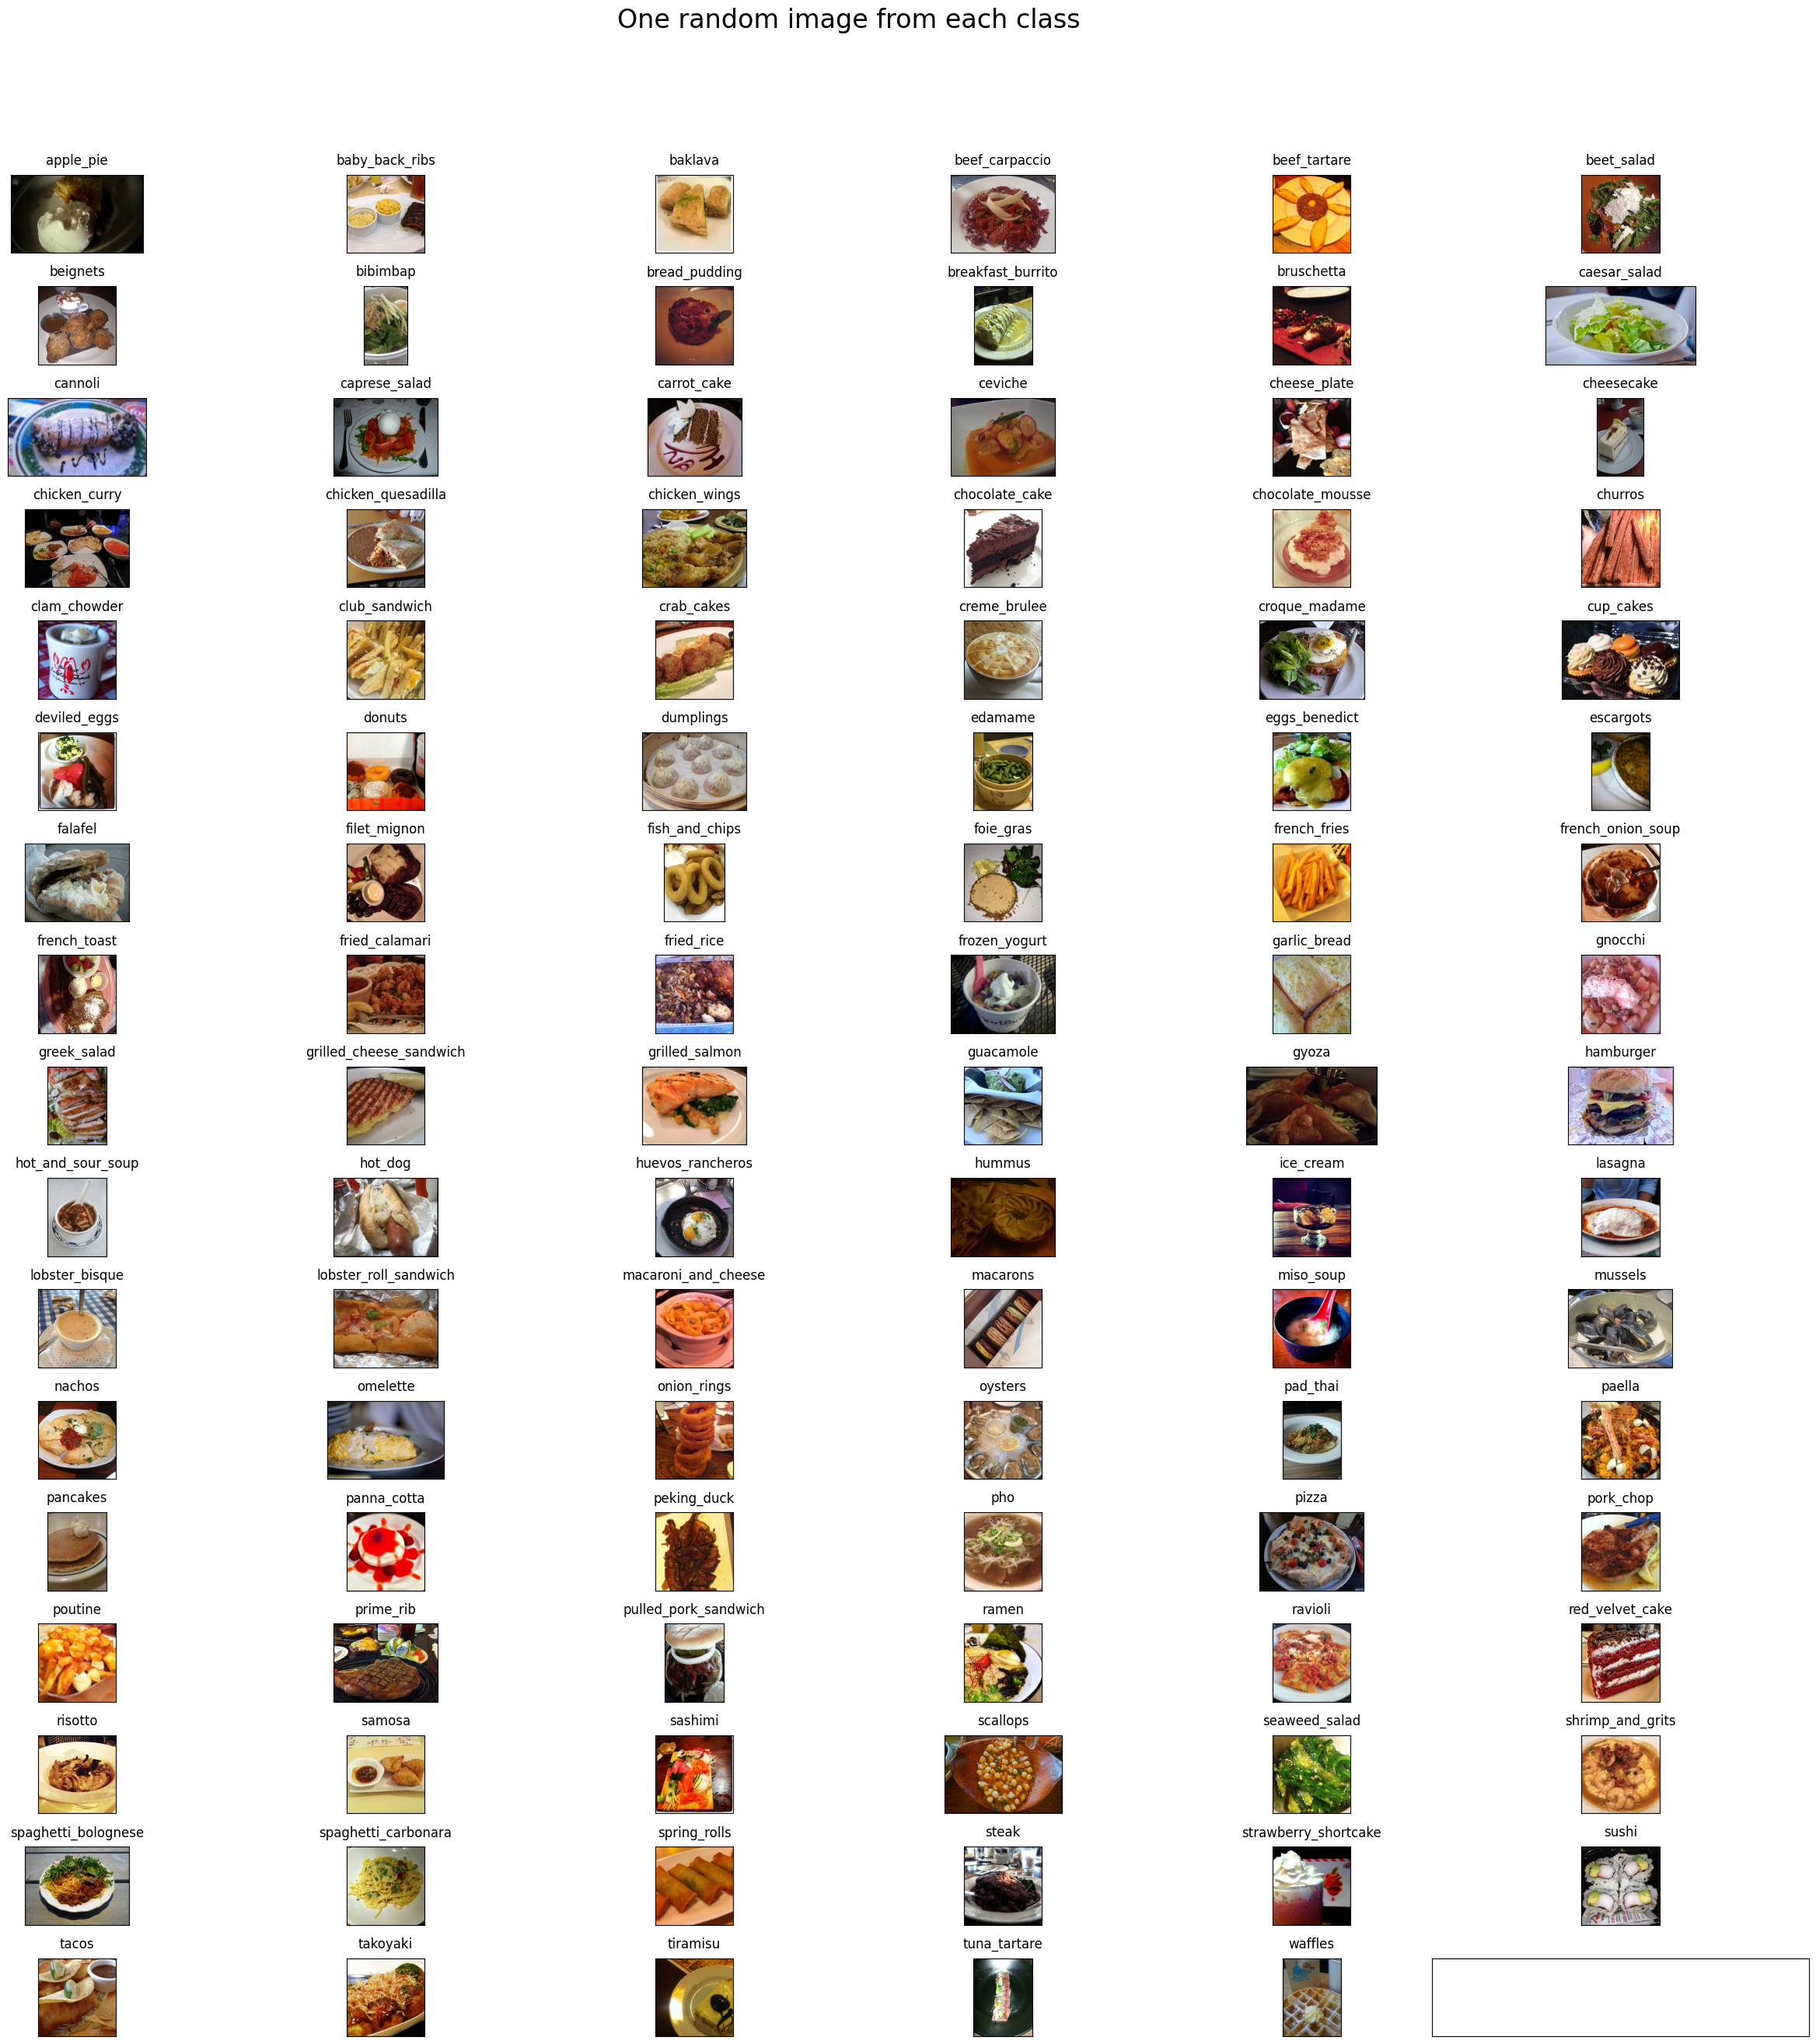

In [ ]:
# Displaying One Random Image from Each Class
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("One random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected))
    food_selected_random = np.random.choice(food_selected_images)
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

#**Preparing Data**

Define a function to prepare the data for training. The function reads a file containing paths to images and copies these images from a source directory to a destination directory, organized by food classes. This step is essential for setting up the dataset in a format suitable for training deep learning models.

In [ ]:
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    for p in paths:
      food = p.split('/')
      classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ", food)
    if not os.path.exists(os.path.join(dest, food)):
      os.makedirs(os.path.join(dest, food))
    for i in classes_images[food]:
      copy(os.path.join(src, food, i), os.path.join(dest, food, i))
  print("Copying done!")

**Creating Train Data**

Create the training data by copying images from the `food-101/images` directory to the `train` directory, organized by food classes. The function `prepare_data` reads the paths to images from the train.txt file and copies them accordingly.

In [ ]:
%cd /
print('Creating train data')
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', 'train')

/
Creating train data

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

**Creating Test Data**

Create the test data by copying images from the `food-101/images` directory to the `test` directory, organized by food classes. The function `prepare_data` reads the paths to images from the test.txt file and copies them accordingly.

In [ ]:
print('Creating train data')
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')

Creating train data

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying image

In [ ]:
# Checking number of files in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Checking number of files in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


# **Creating Mini Data Samples**

Define a helper function to create mini data samples from the Food-101 dataset. The function copies images from the source directory (`src`) for selected food categories (`food_list`) to a destination directory (`dest`).

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest)
  os.makedirs(dest)
  for food_item in food_list:
    print('Copying images into ', food_item)
    copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

In [ ]:
# List of selected food categories for the mini dataset
food_list = ['red_velvet_cake', 'tuna_tartare', 'garlic_bread',
             'chicken_wings', 'grilled_salmon', 'pancakes', 'apple_pie',
             'bread_pudding', 'churros', 'creme_brulee', 'dumplings',
             'fish_and_chips']

# Source and destination directories for train and test datasets
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

**Creating Train Data Folder with New Classes**

Create a mini train dataset folder containing images from the selected food categories. The `dataset_mini` function copies images from the source train directory (`train`) to the destination directory (`train_mini`), organized by the specified food categories.

In [ ]:
# Create mini train dataset folder
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into  red_velvet_cake
Copying images into  tuna_tartare
Copying images into  garlic_bread
Copying images into  chicken_wings
Copying images into  grilled_salmon
Copying images into  pancakes
Copying images into  apple_pie
Copying images into  bread_pudding
Copying images into  churros
Copying images into  creme_brulee
Copying images into  dumplings
Copying images into  fish_and_chips


In [ ]:
# Count the number of files and directories in the mini train folder
print("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
9000


**Creating Test Data Folder with New Classes**

Create a mini test dataset folder containing images from the selected food categories. The `dataset_mini` function copies images from the source test directory (`test`) to the destination directory (`test_mini`), organized by the specified food categories.

In [ ]:
# Create mini test dataset folder
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into  red_velvet_cake
Copying images into  tuna_tartare
Copying images into  garlic_bread
Copying images into  chicken_wings
Copying images into  grilled_salmon
Copying images into  pancakes
Copying images into  apple_pie
Copying images into  bread_pudding
Copying images into  churros
Copying images into  creme_brulee
Copying images into  dumplings
Copying images into  fish_and_chips


In [ ]:
# Count the number of files and directories in the mini test folder
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
3000


# **Setting Up Data Generators**

Set up the data generators for training and validation using Keras `ImageDataGenerator`. These generators will preprocess the images by rescaling the pixel values and applying random transformations such as shearing, zooming, and horizontal flipping. This helps in augmenting the data and improving the robustness of the model.

In [ ]:
# Clear previous session
tf.keras.backend.clear_session()

# Define parameters
n_classes = 12
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 9000
nb_validation_samples = 3000
batch_size = 32

# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation data generators
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 9000 images belonging to 12 classes.
Found 3000 images belonging to 12 classes.


# **Setting Up the MobileNetV2 CNN Model**

Set up the MobileNetV2 Convolutional Neural Network (CNN) model for transfer learning.  We use the pre-trained MobileNetV2 model with weights from ImageNet, excluding the top fully connected layers. We then add our custom layers on top of the MobileNetV2 base model: a global average pooling layer, two dense layers with ReLU activation and L2 regularization, batch normalization after each dense layer, dropout layers for regularization, a final dense layer with softmax activation for classification into 12 classes

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Load MobileNetV2 model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of MobileNetV2 base model with regularizers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Increased dropout rate
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Increased dropout rate
predictions = Dense(n_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 2s 0us/step


#**Setting Up Early Stopping**

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

#**Training the MobileNetV2 CNN Model**

In [ ]:
# Train the model with early stopping and learning rate reduction
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
print(f"Training completed. Best epoch: {early_stopping.best_epoch+1}")

Epoch 1/10
281/281 [==============================] - 287s 883ms/step - loss: 4.3289 - accuracy: 0.3343 - val_loss: 3.2450 - val_accuracy: 0.6159 - lr: 1.0000e-04
Epoch 2/10
281/281 [==============================] - 238s 847ms/step - loss: 3.3289 - accuracy: 0.5787 - val_loss: 2.8139 - val_accuracy: 0.7315 - lr: 1.0000e-04
Epoch 3/10
281/281 [==============================] - 242s 858ms/step - loss: 2.9563 - accuracy: 0.6754 - val_loss: 2.5813 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 4/10
281/281 [==============================] - 235s 836ms/step - loss: 2.6821 - accuracy: 0.7413 - val_loss: 2.4634 - val_accuracy: 0.7890 - lr: 1.0000e-04
Epoch 5/10
281/281 [==============================] - 233s 831ms/step - loss: 2.4551 - accuracy: 0.7814 - val_loss: 2.2438 - val_accuracy: 0.8286 - lr: 1.0000e-04
Epoch 6/10
281/281 [==============================] - 233s 828ms/step - loss: 2.2529 - accuracy: 0.8160 - val_loss: 2.0665 - val_accuracy: 0.8464 - lr: 1.0000e-04
Epoch 7/10
281/281 [==

The model completed 10 epochs of training. It achieved a training loss of 1.5903 with an accuracy of 89.5%. For the validation set, the loss was 1.7793 with an accuracy of 82.39%.

In [ ]:
class_map_12 = train_generator.class_indices
class_map_12

{'apple_pie': 0,
 'bread_pudding': 1,
 'chicken_wings': 2,
 'churros': 3,
 'creme_brulee': 4,
 'dumplings': 5,
 'fish_and_chips': 6,
 'garlic_bread': 7,
 'grilled_salmon': 8,
 'pancakes': 9,
 'red_velvet_cake': 10,
 'tuna_tartare': 11}

# **Plotting Training and Validation Metrics**

Define functions to plot the training and validation accuracy as well as the training and validation loss over epochs. These plots help us visualize the performance of our model during training.

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

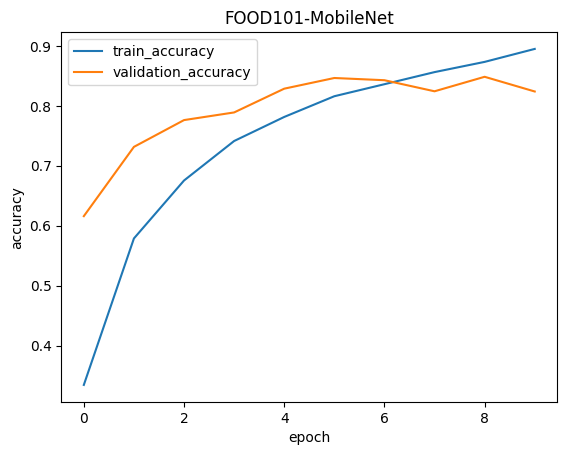

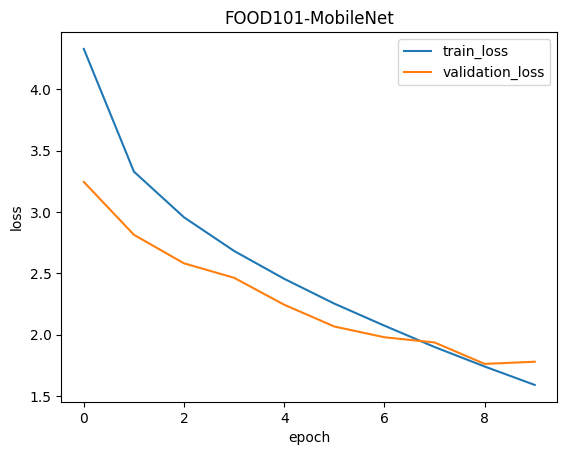

In [ ]:
plot_accuracy(history,'FOOD101-MobileNet')
plot_loss(history,'FOOD101-MobileNet')

**Model Performance:**

Accuracy: An increasing trend indicates that the model is learning well from the training data and is able to generalize to unseen validation data, demonstrating good overall performance.

Loss: A decreasing trend indicates that the model is effectively minimizing errors both in training and on unseen validation data, suggesting good learning and generalization.


# **Mount Google Drive to Save the Trained Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/my_mobilenet_modelC.h5')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Testing Model Performance**

 Predicts the class of given images using the provided model.

In [ ]:
%%time
# Loading the best saved model to make predictions

# Clearing session to reload the model
K.clear_session()

# Loading the best saved model
model_best = load_model('/content/drive/MyDrive/my_mobilenet_modelC.h5',compile = False)

CPU times: user 2.37 s, sys: 47.1 ms, total: 2.42 s
Wall time: 4 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O chickenwings.jpeg https://asset.kompas.com/crops/NQbfszou0zY1L4SahvxstYoG5o8=/0x0:1000x667/750x500/data/photo/2023/01/12/63bf4dd007c11.jpeg
!wget -O applepie.jpg https://www.connoisseurusveg.com/wp-content/uploads/2022/08/vegan-apple-pie-22-sq-2.jpg
!wget -O churros.jpg https://static.promediateknologi.id/crop/0x0:0x0/750x500/webp/photo/p1/405/2024/01/15/IMG_20240113_184300-709151172.jpg
!wget -O dumplings.jpg https://images.squarespace-cdn.com/content/v1/55be995de4b071c106b3b4c0/6af0cbeb-8a58-4993-ab68-8e9919d6d04c/Salmon+Dumplings-6.jpg
!wget -O pancakes.jpg https://tastyoven.com/wp-content/uploads/2021/01/oat-milk-pancakes-image.jpg
!wget -O breadpudding.jpeg https://amiraspantry.com/wp-content/uploads/2022/09/cinnamon-bread-pudding-RC.jpeg
!wget -O garlicbread.jpg https://www.sipandfeast.com/wp-content/uploads/2022/07/garlic-bread-recipe-snippet.jpgnt/uploads/2021/11/bread-pudding-recipe-6.jpg
!wget -O cremebrulee.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/2014_0531_Cr%C3%A8me_br%C3%BBl%C3%A9e_Doi_Mae_Salong_%28cropped%29.jpg/800px-2014_0531_Cr%C3%A8me_br%C3%BBl%C3%A9e_Doi_Mae_Salong_%28cropped%29.jpg
!wget -O fishandchips.jpg https://assets.londonist.com/uploads/2023/02/i875/fish-and-chips.jpg
!wget -O grilledsalmon.jpg https://www.thecookierookie.com/wp-content/uploads/2023/05/featured-grilled-salmon-recipe.jpg
!wget -O garlicbread.jpg https://spicecravings.com/wp-content/uploads/2021/09/Air-Fryer-Garlic-Bread-Featured.jpg

--2024-06-20 19:32:11--  https://asset.kompas.com/crops/NQbfszou0zY1L4SahvxstYoG5o8=/0x0:1000x667/750x500/data/photo/2023/01/12/63bf4dd007c11.jpeg
Resolving asset.kompas.com (asset.kompas.com)... 18.155.68.122, 18.155.68.53, 18.155.68.20, ...
Connecting to asset.kompas.com (asset.kompas.com)|18.155.68.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79298 (77K) [image/jpeg]
Saving to: ‘chickenwings.jpeg’

chickenwings.jpeg   100%[===================>]  77.44K  --.-KB/s    in 0.003s  

2024-06-20 19:32:11 (23.5 MB/s) - ‘chickenwings.jpeg’ saved [79298/79298]

--2024-06-20 19:32:11--  https://www.connoisseurusveg.com/wp-content/uploads/2022/08/vegan-apple-pie-22-sq-2.jpg
Resolving www.connoisseurusveg.com (www.connoisseurusveg.com)... 104.18.4.29, 104.18.5.29, 2606:4700::6812:51d, ...
Connecting to www.connoisseurusveg.com (www.connoisseurusveg.com)|104.18.4.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68111 (67K) [image/jpeg]


1/1 [==============================] - 3s 3s/step


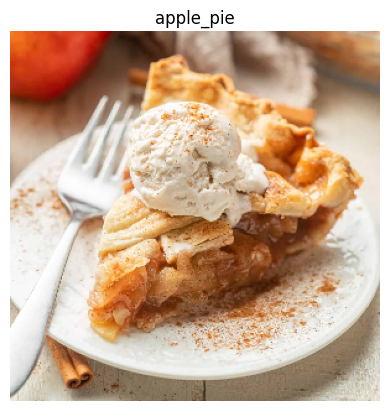

1/1 [==============================] - 0s 23ms/step


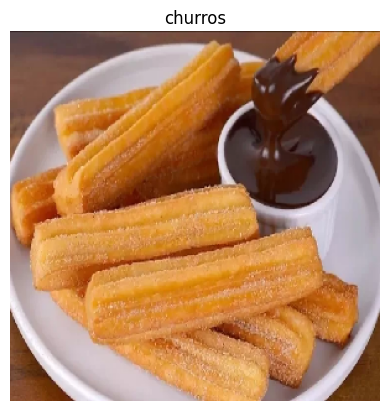

1/1 [==============================] - 0s 24ms/step


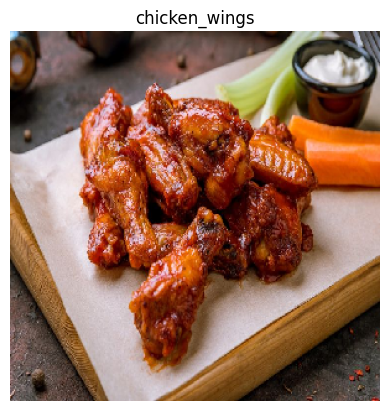

1/1 [==============================] - 0s 33ms/step


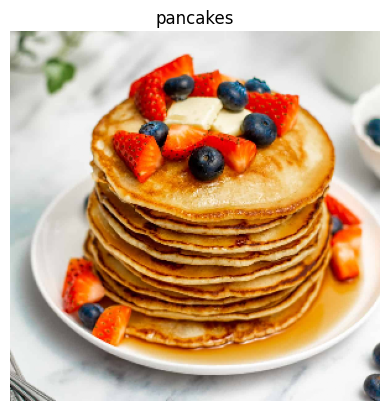

1/1 [==============================] - 0s 42ms/step


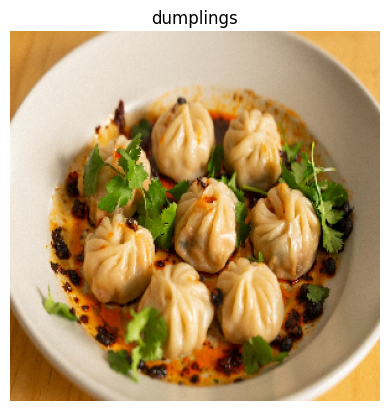

1/1 [==============================] - 0s 35ms/step


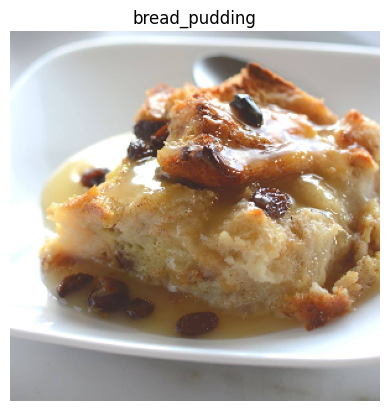

1/1 [==============================] - 0s 32ms/step


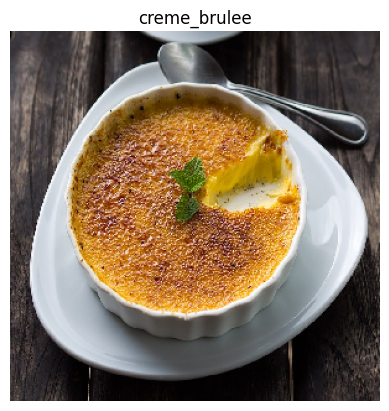

1/1 [==============================] - 0s 32ms/step


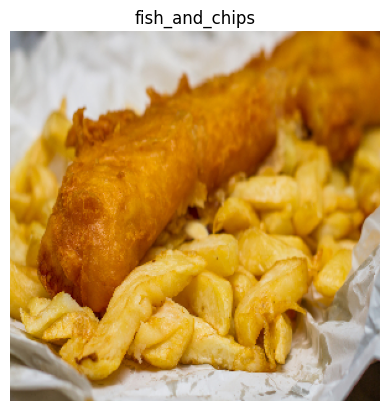

1/1 [==============================] - 0s 53ms/step


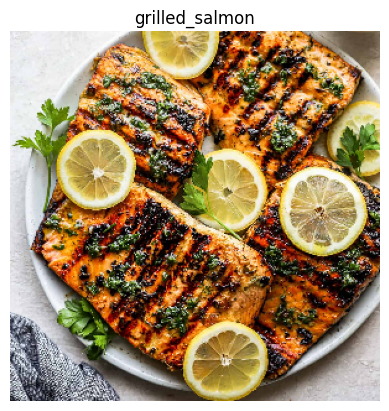

1/1 [==============================] - 0s 35ms/step


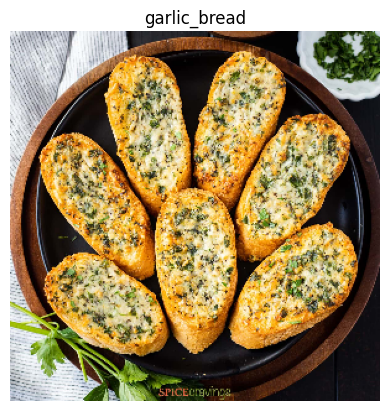

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('churros.jpg')
images.append('chickenwings.jpeg')
images.append('pancakes.jpg')
images.append('dumplings.jpg')
images.append('breadpudding.jpeg')
images.append('cremebrulee.jpg')
images.append('fishandchips.jpg')
images.append('grilledsalmon.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

The testing outcomes for identifying the food names from each image have demonstrated promising results. Out of the 11 images used for testing, the model accurately predicted all 11 food names.

# **Download the Trained Model From Google Drive**

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/my_mobilenet_modelC.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Convert and Save the Model to TensorFlow Lite Format**

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter = True

tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = '/content/drive/MyDrive/my_mobilenet_modelC.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# **Test the TensorFlow Lite Model**

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare sample input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output tensor
tflite_results = interpreter.get_tensor(output_details[0]['index'])

# Print inference results
print("TensorFlow Lite prediction:")
print(tflite_results)

TensorFlow Lite prediction:
[[0.05715217 0.0440473  0.13247076 0.14350232 0.06750114 0.02640988
  0.04843762 0.0008358  0.00452383 0.17442927 0.2804608  0.02022909]]


In [ ]:
import numpy as np

prediction = np.array([[0.05715217, 0.0440473, 0.13247076, 0.14350232, 0.06750114, 0.02640988,
                        0.04843762, 0.0008358, 0.00452383, 0.17442927, 0.2804608,  0.02022909]])
predicted_class = np.argmax(prediction)
print(f"Predicted class: {predicted_class}")

Predicted class: 2


# **Download the TensorFlow Lite Model From Google Drive**

In [ ]:
from google.colab import files

# Path to your TFLite model
tflite_model_path = '/content/drive/MyDrive/my_mobilenet_modelC.tflite'

# Download the TFLite model
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>